# 1. Mining Diamond Data - Blue Nile®

## (a) Introduction
In this series of notebooks we are mining diamond data from merchants on the web, and subsequently using Machine Learning to be able to predict the price of a diamond. Diamond merchants often display data on the diamonds they are selling so people can peruse them and make a purchase online. They'll also usually have a comparison element with lots of features (the 5 C's etc.). Really though, if you're anything like me (a noob jeweller), how can you tell how the diamond is priced based on these features? I guess you'd have to take the merchants' word on it... 

What we need is data, and a regression algorithm looking at price. This notebook is the first in the series, and in it we'll tackle scraping Blue Nile® data from [their website](https://www.bluenile.com/uk/diamond-search) (soz Blue Nile... but thx for the data). 

In all seriousness, this data is the property of Blue Nile®, so please be respectful. I try and stick to web scraping best practises in these scripts, so if you are going to use it, please keep these in. They mostly revolve around slowing the functions down, which I realise may be frustrating, but let's keep to the code people.

We'll start by importing our packages and defining a couple of functions.

## (b) Import packages / define functions

In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.rcParams['figure.figsize'] = [12, 7]

from bs4 import BeautifulSoup
import requests
import re

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains

import itertools
import time # To help slow our functions down and time them
import random # To assign random floats to breaks, hiding predictable patterns

The below two functions are essential to working with HTML data, and we'll use these a lot throughout the notebook.

In [2]:
def pause_random(start=0.3, stop=2):
    """
    Pause the function for a random amount of time between the two integers entered.
    """
    time.sleep(random.uniform(start, stop))

In [3]:
def get_page_content(page_link):
    """
    Scrape the targeted HTML and store as a bs object
    """
    page_response = requests.get(page_link, timeout=5)
    page_content = BeautifulSoup(page_response.content)
    return(page_content)

In [4]:
def cleanhtml(raw_html):
    """
    Remove HTML tags from string.
    """
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return(cleantext)

## (c) Prepare Blue Nile® dataset

In this section we create a function to prepare the Blue Nile table, and do some intial exploration to help our final crawler save time.
For reference, I denote Blue Nile® as `bn` for short.

In [5]:
# For conciseness, Blue Nile we will denote as 'bn'
bn_link = 'https://www.bluenile.com/uk/diamond-search'

In [6]:
# Start web driver
browser = webdriver.Chrome('C:/Users/Edward Sims/Downloads/chromedriver.exe')
browser.get(bn_link)
pause_random()

In [7]:
def prep_bn_table(link):
    """
    Opens webdriver and prepares the table for scraping.
    """
    
    # Continue past the cookie notice if it exists
    try:
        cookie_continue = browser.find_element_by_xpath('/html/body/div[1]/button[3]')
        cookie_continue.click()
    except:
        pass

    # If the 360 view option is checked, uncheck it
    view_checkbox_status = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[4]/div[2]/div/div/div[1]/div/div')
    view_checkbox_status = str(view_checkbox_status.get_attribute('innerHTML'))
    if 'checked' in view_checkbox_status:
        view_checkbox = browser.find_element_by_class_name('bn-checkbox')
        view_checkbox.click()
        pause_random()

    # If astor option is checked, uncheck it
    astor_checkbox_status = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[5]/div[2]/div/div/div[1]/div/div')
    astor_checkbox_status = str(astor_checkbox_status.get_attribute('innerHTML'))
    if 'checked' in astor_checkbox_status:
        astor_checkbox = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[5]/div[2]/div/div')
        astor_checkbox.click()
        pause_random()
        
    # If more filters is unselected, select it    
    filter_status = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[13]/span')
    filter_status = str(filter_status.get_attribute('innerHTML'))
    if 'More' in filter_status:
        more_filters = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[13]')
        more_filters.click()
    
    # Add extra options if they are not already added
    polish_add = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[12]/div[1]/div[1]/div/div')
    symmetry_add = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[12]/div[2]/div[1]/div/div')
    fluorescence_add = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[12]/div[3]/div[1]/div/div')
    depth_add = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[12]/div[4]/div[1]/div/div')
    table_add = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[12]/div[5]/div[1]/div/div')
    lw_add = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[12]/div[6]/div[1]/div/div')
    
    feature_add_all = [polish_add, symmetry_add, fluorescence_add, depth_add, table_add, lw_add]
    for feature_add in feature_add_all:
        if 'toggled' not in str(feature_add.get_attribute('outerHTML')):
            feature_add.click()
            pause_random()
            
    culet_add = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[12]/div[8]/div[2]/button')
    if 'active' not in str(culet_add.get_attribute('outerHTML')):
        culet_add.click()
        pause_random()
    
    # Add in all types of shape
    round_details = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[6]/div[2]/div/div[1]/div[3]')
    princess_details = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[6]/div[2]/div/div[2]/div[3]')
    emerald_details = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[6]/div[2]/div/div[3]/div[3]')
    asscher_details = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[6]/div[2]/div/div[4]/div[3]')
    cushion_details = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[6]/div[2]/div/div[5]/div[3]')
    marquise_details = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[6]/div[2]/div/div[6]/div[3]')
    radiant_details = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[6]/div[2]/div/div[7]/div[3]')
    oval_details = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[6]/div[2]/div/div[8]/div[3]')
    pear_details = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[6]/div[2]/div/div[9]/div[3]')
    heart_details = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[6]/div[2]/div/div[10]/div[3]')
    
    shape_details_all = [round_details, princess_details, emerald_details, asscher_details, cushion_details, 
                         marquise_details, radiant_details, oval_details, pear_details, heart_details]
    
    for shape_details in shape_details_all:
        if 'selected' not in str(shape_details.get_attribute('outerHTML')):
            shape_details.click()
            pause_random()

In [8]:
# Open and prepare the bn table for scraping
prep_bn_table(bn_link)

## (d) Scrape the data
The difficulty with scraping the table is that a maximum of 1,000 results are displayed. And the prices of diamonds are hugely skewed around the £600-£2,000 price range. 

So we've arrived at our first major problem: 
 - If we increment our price by static small amounts, it'll take weeks (umm no thanks).
 - If we increment them by static large amounts, we'll miss out loads of data from the price ranges with high frequencies.

My solution below follows this method:
 1. Retrieve the headers for our table
 2. Create an initial price interval
 3. Check the number of results displayed.
 4. If more than 999, make an estimate on the sub intervals that will approximately yield 999 or less results. Scrape the table in each sub interval.
 5. If under 999, scrape the table.
 6. Tracking the cumulative number of results, once there are less than 999 results left, skip to the maximum price and scrape the table. 

In [9]:
def get_bn_data():
    """
    Loops through all the price values, scrapes the results and stores
    it into a dataframe.
    """
    
    def get_num_results():
        """
        Scrapes the number of results shown in the price range.    
        """
        results_path = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[2]/div[4]/button[1]/span[2]')
        # Scrape HTML and clean
        results_val = cleanhtml(str(BeautifulSoup(results_path.get_attribute('innerHTML'))))
        # Strip  punctuation, and convert to integer
        results_val = int(re.sub(r'[^\w\s]','', results_val))
        return(results_val)
    
    start = time.time()
    bn_headers = []
    # Isolate the table headers HTML
    headers_data = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/section/div/div/div[1]/div')
    headers_html = BeautifulSoup(headers_data.get_attribute('innerHTML'))
    
    # Get the header values
    for div in headers_html.find_all('div'):
        for header in div.find_all('span'):
            bn_headers.append(cleanhtml(str(header)))
    bn_headers = list(filter(('').__ne__, bn_headers))
    bn_headers.remove('Compare')
    # Create a dataframe with our new headers
    bn_df = pd.DataFrame(columns = bn_headers)  
    
    # Min and max price locations
    min_price_box = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[7]/div[2]/div/div[1]/input[1]')
    max_price_box = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[7]/div[2]/div/div[1]/input[2]')
    
    # Assign default interval value
    price_interval = 1000
    
    # Get min and max values (without £ and comma values)
    min_price_value = int(min_price_box.get_attribute('value')[1:].replace(',', ''))
    min_price_value = min_price_value - 1 # Minus 1, so we can add 1 in the loop
    max_price_value = int(max_price_box.get_attribute('value')[1:].replace(',', ''))
    # Find a neutral zone to click on
    neutral = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[7]/div[1]/h3')
    
    total_freq = get_num_results()
    cumul_freq = 0 # To cumulitively add the freqs as we go
    
    def bn_scrape_table():
            bn_table = pd.DataFrame(columns = bn_headers)
            table_web_source = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/section/div/div/div[2]')
            table_html = BeautifulSoup(table_web_source.get_attribute('innerHTML'))
            # Scrape the table! First get the raw table html
            table_rows_html = table_html.find_all('a',{'class':'grid-row row '})
            # Then loop through each row 
            for row in table_rows_html:
                bn_data = []
                # And loop through each value
                for value in row.find_all('span'):
                    bn_data.append(cleanhtml(str(value)))
                bn_data = list(filter(('').__ne__, bn_data)) # Remove all empty values
                del bn_data[4] # Delete index 4 in list as it returns two dupe vals - unique to their HTML
                
                bn_dict = dict(zip(bn_headers, bn_data))
                bn_table = bn_table.append(bn_dict, ignore_index=True)
            return(bn_table)
    
    # Loop through prices
    for min_val in range(min_price_value, max_price_value, price_interval):
        
        lower_price = min_val + 1 # Add 1 so there are no overlapping intervals
        higher_price = min_val + price_interval
        
        # Edit max price
        max_price_box.click()
        max_price_box.send_keys(Keys.BACKSPACE)
        max_price_box.send_keys(str(higher_price)) 
        neutral.click()
        time.sleep(random.uniform(0,1))
        # Edit min price            
        min_price_box.click()
        min_price_box.send_keys(Keys.BACKSPACE)
        min_price_box.send_keys(str(lower_price))
        neutral.click()
        time.sleep(random.uniform(1,3)) 
        
        freq = get_num_results()
        cumul_freq = cumul_freq + freq 
        
        if (total_freq - cumul_freq) <= 999:
            browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            pause_random(7,8) # Wait for the table to load
            
            bn_df = bn_df.append(bn_scrape_table(), ignore_index=True)
            
            # Edit max price
            max_price_box.click()
            max_price_box.send_keys(Keys.BACKSPACE)
            max_price_box.send_keys(str(max_price_value)) 
            neutral.click()
            time.sleep(random.uniform(0,1))
            # Edit min price            
            min_price_box.click()
            min_price_box.send_keys(Keys.BACKSPACE)
            min_price_box.send_keys(str(lower_price + price_interval))
            neutral.click()
            time.sleep(random.uniform(0,1))
            
            browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            pause_random(7,8) # Wait for the table to load
            
            bn_df = bn_df.append(bn_scrape_table(), ignore_index=True)
            break 
        else:           
            # If there are over 999 results, divide the interval into smaller
            # intervals that approximately return 999 or less results for each.
            if freq > 999:
                sub_interval_number = freq / 999
                sub_interval_price = round(price_interval / sub_interval_number)
                
                sub_min_price_value = lower_price - 1
                sub_max_price_value = higher_price
                
                for min_val in range(sub_min_price_value, sub_max_price_value, sub_interval_price):
                    
                    sub_lower_price = min_val + 1 # Add 1 so there are no overlapping intervals
                    sub_higher_price = min_val + sub_interval_price
                    
                    # Edit max price
                    max_price_box.click()
                    max_price_box.send_keys(Keys.BACKSPACE)
                    max_price_box.send_keys(str(sub_higher_price)) 
                    neutral.click()
                    time.sleep(random.uniform(0,1))
                    # Edit min price            
                    min_price_box.click()
                    min_price_box.send_keys(Keys.BACKSPACE)
                    min_price_box.send_keys(str(sub_lower_price))
                    neutral.click()
                    time.sleep(random.uniform(0,1))
                    
                    browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                    pause_random(7,8) # Wait for the table to load
                    
                    bn_df = bn_df.append(bn_scrape_table(), ignore_index=True)
            
    end = time.time()
    print((end - start) / 60, 'mins to complete')
    return(bn_df)

In [10]:
bn_df = get_bn_data()

47.12620820204417 mins to complete


In [11]:
bn_df.to_csv('blue_nile_data.csv', index=False)

In [49]:
print(bn_df.shape)
bn_df.head()

(173725, 14)


,shape,price,carat,cut,color,clarity,polish,symmetry,fluorescence,depth,table,l/w,price/ct,culet
0,Emerald,214.8,0.30,Good,I,VS1,Very Good,Very Good,None,68.6,74.0,1.24,716.0,None
1,Pear,219.6,0.31,Very Good,J,SI2,Very Good,Good,Faint,61.8,56.0,1.51,708.0,None
2,Princess,238.8,0.25,Very Good,D,SI1,Excellent,Very Good,None,73.4,73.0,1.05,955.0,None
3,Pear,248.4,0.31,Very Good,G,SI2,Good,Good,None,62.2,64.0,1.62,801.0,None
4,Pear,249.6,0.29,Very Good,E,SI2,Very Good,Good,None,65.7,59.0,1.50,861.0,None


## (e) Modelling

Later I'll compile all the other datasets and create notebooks for the EDA, engineering, HP tuning, modelling etc. But for now I'm just too eager to take a peek at the model! So we'll just fit a quick and dirty random forest regressor and see what happens...

In [6]:
bn_df = pd.read_csv('blue_nile_data.csv')

In [7]:
# Convert currency features to floats
bn_df['Price'] = bn_df['Price'].replace('[\£,]', '', regex=True).astype(float)
bn_df['Price/Ct'] = bn_df['Price/Ct'].replace('[\£,]', '', regex=True).astype(float)

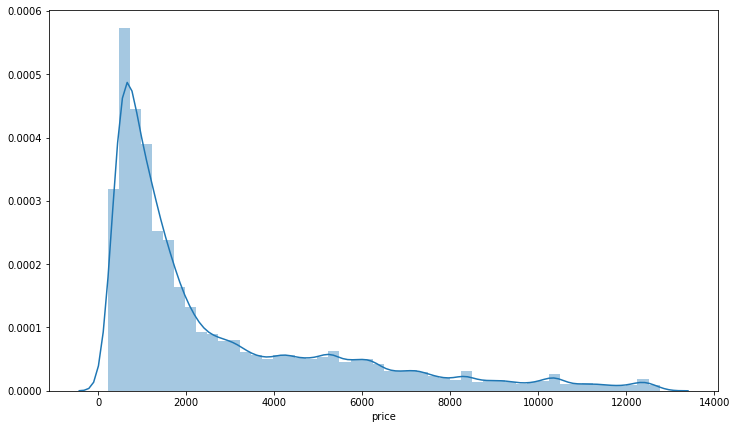

In [52]:
sns.distplot(bn_df['price'].iloc[0:170000], hist=True)
plt.show()

In [21]:
bn_df = bn_df.drop('Unnamed: 0', 1)

In [28]:
bn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173725 entries, 0 to 173724
Data columns (total 16 columns):
Shape            173725 non-null object
Price            173725 non-null float64
Carat            173725 non-null float64
Cut              173725 non-null object
Color            173725 non-null object
Clarity          173725 non-null object
Polish           173725 non-null object
Symmetry         173725 non-null object
Fluorescence     173725 non-null object
Depth            173725 non-null float64
Table            173725 non-null float64
L/W              173725 non-null float64
Price/Ct         173725 non-null float64
Culet            173725 non-null object
Stock No.        173725 non-null object
Dispatch Date    173725 non-null object
dtypes: float64(6), object(10)
memory usage: 21.2+ MB


We won't need the `Dispatch Date` and `Stock No`. Also, for ease of use, let's remove all caps from our feature names. 

In [35]:
bn_df = bn_df.drop(['Stock No.', 'Dispatch Date'], 1)
bn_df.columns = map(str.lower, bn_df.columns)

In [53]:
bn_df.describe()

,price,carat,depth,table,l/w,price/ct
count,1.737250e+05,173725.000000,173725.000000,173725.000000,173725.000000,173725.000000
mean,4.044132e+03,0.721589,63.087385,59.140318,1.061930,3488.371518
std,2.148277e+04,0.572284,3.270146,3.790387,0.156758,3265.017487
min,2.148000e+02,0.230000,51.000000,5.000000,0.800000,708.000000
25%,7.764000e+02,0.400000,61.500000,57.000000,1.000000,1924.000000
50%,1.521600e+03,0.550000,62.400000,58.000000,1.010000,2676.000000
75%,4.138800e+03,1.000000,63.500000,60.000000,1.010000,4293.000000
max,2.127884e+06,20.970000,80.000000,85.000000,3.460000,138444.000000


C:\Users\Edward Sims\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


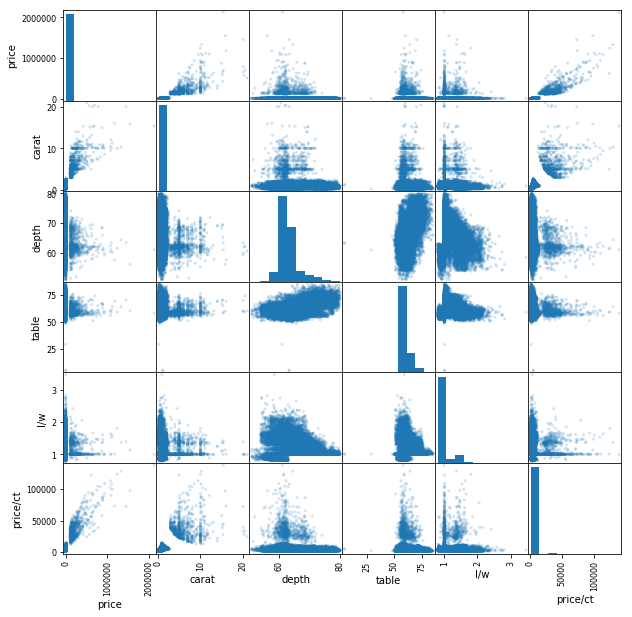

In [54]:
pd.scatter_matrix(bn_df, alpha=0.2, figsize=(10, 10))
plt.show()

In [91]:
bn_df_categorical = bn_df.select_dtypes(include='object')
bn_df_numerical = bn_df.select_dtypes(include='float64')

C:\Users\Edward Sims\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


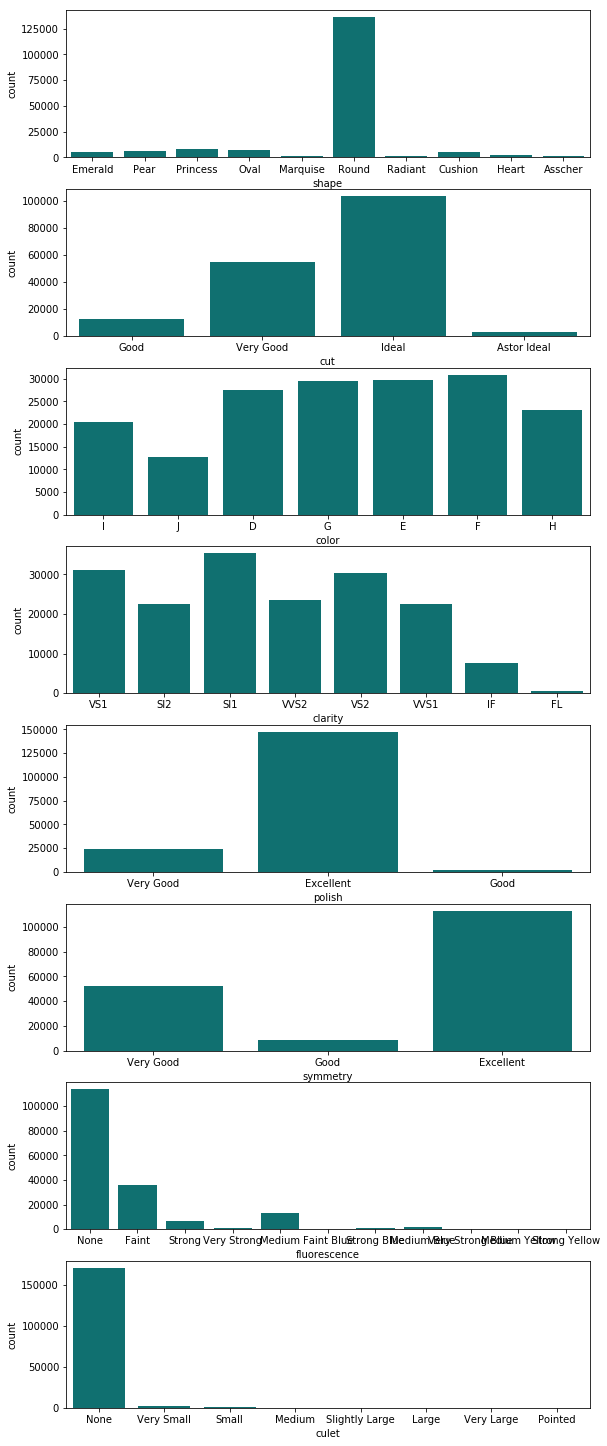

In [139]:
fig, ax = plt.subplots(8,1,figsize = (8,20))
fig.tight_layout()
for i, feature in enumerate(bn_df_categorical.columns):
    plot = sns.countplot(bn_df_categorical[feature], color='teal', ax=ax[i], )
fig.show()

We'll remove the `culet` feature do to a the low variance. 

In [ ]:
bn_df = bn_df.drop('culet', 1)

Next we need to decide what to do with the categorical features - whether to one-hot encode them or map them top some kind of ordinal number. Turns out there are pretty clear scales for all features except fluorescence. We'll one-hot encode this, along with shape.

In [183]:
# Cut
cut_scale_dict = dict(zip(bn_df['cut'].unique(), [0,1,2,3]))
# Color
color_scale_dict = dict(zip(sorted(bn_df['color'].unique()), range(0,len(bn_df['color'].unique()))))
# Clarity - had to do some research for this
clarity_scale_dict = dict(zip(bn_df['clarity'].unique(), [3,6,5,2,4,1,0,0]))
# Polish
polish_scale_dict = dict(zip(bn_df['polish'].unique(), [1,2,0]))
# Symmetry
symmetry_scale_dict = dict(zip(bn_df['symmetry'].unique(), [1,0,2]))

In [184]:
bn_df = bn_df.replace({'cut': cut_scale_dict})
bn_df = bn_df.replace({'color': color_scale_dict})
bn_df = bn_df.replace({'clarity': clarity_scale_dict})
bn_df = bn_df.replace({'polish': polish_scale_dict})
bn_df = bn_df.replace({'symmetry': symmetry_scale_dict})
bn_df.head()

,shape,price,carat,cut,color,clarity,polish,symmetry,fluorescence,depth,table,l/w,price/ct
0,Emerald,214.8,0.30,0,5,3,1,1,None,68.6,74.0,1.24,716.0
1,Pear,219.6,0.31,1,6,6,1,0,Faint,61.8,56.0,1.51,708.0
2,Princess,238.8,0.25,1,0,5,2,1,None,73.4,73.0,1.05,955.0
3,Pear,248.4,0.31,1,3,6,0,0,None,62.2,64.0,1.62,801.0
4,Pear,249.6,0.29,1,1,6,1,0,None,65.7,59.0,1.50,861.0


In [198]:
# lower case all values and replace white spaces with underscores
bn_df['shape'] = bn_df['shape'].str.lower()

bn_df['fluorescence'] = bn_df['fluorescence'].str.lower()
bn_df['fluorescence'] = bn_df['fluorescence'].replace(' ', '_', regex=True)

In [199]:
def dummies(df, columns):
    for column in columns:
        df[column] = df[column].apply(lambda x: str(x))
        df = pd.concat((df, pd.get_dummies(df[column], prefix = column)), axis = 1)
        df = df.drop(column, 1)
    return df

In [200]:
bn_df_final = dummies(bn_df, ['shape', 'fluorescence'])

In [208]:
# Due to the high variance, we'll log our price value
bn_df_final['price'] = np.log(bn_df_final['price'])

In [210]:
bn_df_final.head()

,price,carat,cut,color,clarity,polish,symmetry,depth,table,l/w,...,fluorescence_faint_blue,fluorescence_medium,fluorescence_medium_blue,fluorescence_medium_yellow,fluorescence_none,fluorescence_strong,fluorescence_strong_blue,fluorescence_strong_yellow,fluorescence_very_strong,fluorescence_very_strong_blue
0,5.369707,0.30,0,5,3,1,1,68.6,74.0,1.24,...,0,0,0,0,1,0,0,0,0,0
1,5.391808,0.31,1,6,6,1,0,61.8,56.0,1.51,...,0,0,0,0,0,0,0,0,0,0
2,5.475626,0.25,1,0,5,2,1,73.4,73.0,1.05,...,0,0,0,0,1,0,0,0,0,0
3,5.515040,0.31,1,3,6,0,0,62.2,64.0,1.62,...,0,0,0,0,1,0,0,0,0,0
4,5.519860,0.29,1,1,6,1,0,65.7,59.0,1.50,...,0,0,0,0,1,0,0,0,0,0


In [286]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [263]:
X = bn_df_final.loc[:, bn_df_final.columns != 'price']
y = bn_df_final['price'] # temporarily keep LoanRef in the y set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 10)

In [221]:
rf = RandomForestRegressor(max_features = 'auto', random_state = 10, n_jobs = -1)

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

start = time.time()

gs = GridSearchCV(estimator = rf, 
                  param_grid = param_grid, 
                  n_jobs = -1)

gs = gs.fit(X_train, y_train)
end = time.time()
print('Time taken: ', end - start, 'secs')

Time taken:  9367.77056980133 secs


In [223]:
gs.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 300}

In [264]:
rf = RandomForestRegressor(n_estimators = 300,
                             min_samples_split = 8,
                             min_samples_leaf = 3,
                             max_depth = 80,
                             max_features = 3,
                             random_state = 10,
                             n_jobs = -1)
start = time.time()

rf_reg = rf.fit(X_train, y_train)

end = time.time()
print('Time taken: ', end - start, 'secs')

Time taken:  11.624614238739014 secs


In [265]:
y_pred = rf.predict(X_test)

In [266]:
rf_training_accuracy = rf.score(X_train, y_train)
rf_test_accuracy = rf_reg.score(X_test, y_test)
rf_mse = mean_squared_error(y_test, y_pred)
print("R^2 on training data: %0.4f" % (rf_training_accuracy))
print("R^2 on test data:     %0.4f" % (rf_test_accuracy))
print("MSE on test data:     %0.4f" % (rf_mse))

R^2 on training data: 0.9865
R^2 on test data:     0.9821
MSE on test data:     0.0195


For a first time run through, an MSE of 0.0195 is really good!

In [302]:
results = pd.DataFrame({'actual':np.exp(y_test), 'pred': np.exp(y_pred)})

In [299]:
print("MSE on test data:     %0.4f" % (mean_absolute_error(np.exp(y_test), np.exp(y_pred))))

MSE on test data:     1130.1007


In [303]:
results.head(30)

,actual,pred
143549,5546.4,4800.734333
65505,1112.4,1088.643704
73202,1212.0,1216.405509
163924,9963.6,9103.570482
69155,1166.4,1179.944195
117586,2854.8,2757.705491
87404,1538.4,1499.220638
34004,674.4,687.792626
64024,1087.2,1109.573462
56126,952.8,926.330103
